# 检验趋势策略的趋势性

参考文献：https://mp.weixin.qq.com/s/Mhu2SB6AMzga_Y1pvwM6PQ

In [8]:
import sys
sys.path.append('C:\\Users\\xpy\\work\\strategies2py\\AprilQuant')
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import empyrical

from backtest.tester import Tester
from backtest.indicators import ATR, AllNaError
from backtest.return_rate_calculations import (
    cal_avg_cum_ret, 
    avg_cum_ret_from_cursor, 
    cal_ret, 
    cum_ret_from_doc
)
from backtest.check_for_momentum import (
    get_cum_ret_dict,
    cal_strategy_overall_tendency,
    cal_strategy_overall_tendency,
    ATR_position_sizing
)
from utils import query, plot_curves
from consts import C_DAILY

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

DB = 'C74'
LEVEL = '15min'

cum_ret_dict = get_cum_ret_dict(DB, LEVEL, date_length=10, ma_length=12, eatr_pcnt=3, trs=0.14, lqk_width=0.1, lqk_floor=0.5)

## 1.检验假设：策略在所有品种上具有相同周期的动量效应
检验方法与参考文献相同。  
可以发现，对于任何长度的历史期和预测期，历史期与预测期收益率相关系数显著为负的比例明显高于相关系数显著为正的比例，证明策略在所有品种相同周期上有具有更强的反转效应而非动量效应。假设不能成立。

In [9]:
hist_len_rng = (240, 480, 720, 960, 1200)
pred_len_rng = (20, 60, 120, 240)

params = [
    (hist_len, pred_len) 
    for pred_len in pred_len_rng 
    for hist_len in hist_len_rng
]
lines = []
for param in params:
    line = cal_strategy_overall_tendency(cum_ret_dict, hist_len=param[0], pred_len=param[1])
    lines.append(line)
summary = pd.DataFrame(lines).sort_values('hist_len')
display(summary)

,hist_len,pred_len,category_num,sig_pos_related,sig_neg_related,successful_prediction
0,240,20,60,0.183333,0.650000,0.083333
5,240,60,59,0.271186,0.694915,0.152542
10,240,120,57,0.263158,0.684211,0.315789
15,240,240,57,0.245614,0.666667,0.385965
1,480,20,56,0.089286,0.750000,0.017857
6,480,60,54,0.148148,0.759259,0.055556
11,480,120,54,0.148148,0.796296,0.314815
16,480,240,53,0.132075,0.792453,0.396226
2,720,20,53,0.056604,0.792453,0.018868
17,720,240,52,0.134615,0.807692,0.480769


## 2. 多品种策略表现
固定比例法ATR_position_sizing在分钟级数据上有bug（返回值是一列NA），尚未能排查出原因。
（但是matplotlib能对这列NA画出曲线）

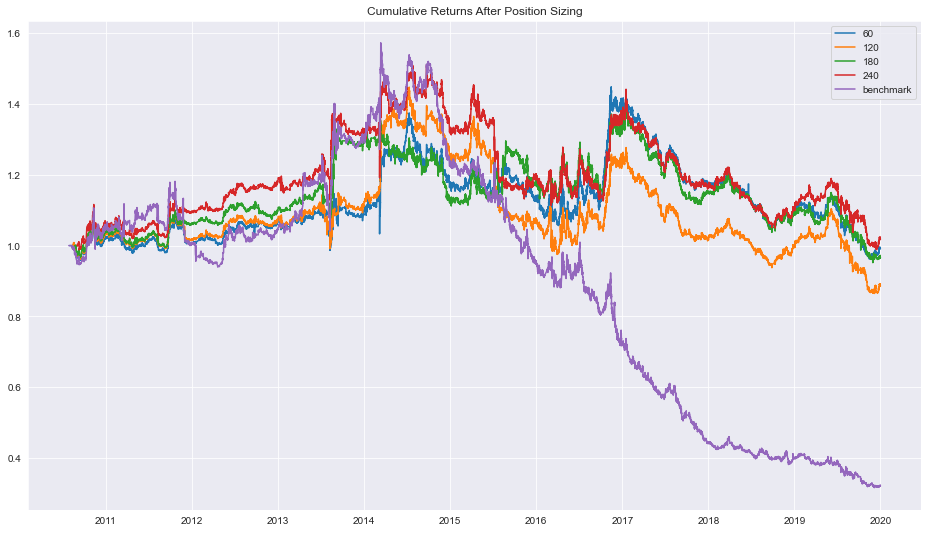

In [10]:
atr_length_rng = (60, 120, 180, 240)

weighted_cum_rets = [
    ATR_position_sizing(cum_ret_dict, LEVEL, atr_length, atr_length) 
    for atr_length in atr_length_rng
]
benchmark = cal_avg_cum_ret(cum_ret_dict.values())

plot_curves([*weighted_cum_rets, benchmark], 'Cumulative Returns After Position Sizing', [*atr_length_rng, 'benchmark'])

In [11]:
for atr_length, cum_ret in zip([*atr_length_rng, None], weighted_cum_rets + [benchmark]):
    sr = empyrical.sharpe_ratio(cal_ret(cum_ret))[0]
    output_string = f'使用 {atr_length} 期ATR调整仓位: ' if atr_length is not None \
                else '不调整仓位：            '
          
    output_string += f'累计收益率为 {cum_ret.cum_ret.tolist()[-1]} '
    output_string += f'Sharpe Ratio 为 {sr}'
    print(output_string)

使用 60 期ATR调整仓位: 累计收益率为 nan Sharpe Ratio 为 0.14883351803877456
使用 120 期ATR调整仓位: 累计收益率为 nan Sharpe Ratio 为 0.11316458023639137
使用 180 期ATR调整仓位: 累计收益率为 nan Sharpe Ratio 为 0.16351410237275277
使用 240 期ATR调整仓位: 累计收益率为 nan Sharpe Ratio 为 0.17398369353129312
不调整仓位：            累计收益率为 0.3213536150629288 Sharpe Ratio 为 -0.10702930555797958
